In [1]:
import pandas as pd
import numpy as np
from jupyterthemes import jtplot

jtplot.style()

import statsmodels.api as sm

In [2]:
df = pd.read_csv('./../data/Monsteruitslagen_Resultaten.csv')
df['datetime'] = pd.to_datetime(df.datum + ' ' + df.tijd)

def convert_tappunt(x):
    x = str(x).lower()
    if 'thermostatische douchemengkraan' in x or 'therm.' in x:
        return 'douche'
    if 'douche' in x:
        return 'douche'
    if '1e tappunt' in x:
        return '1e tappunt'
    return 'overige'

def convert_ruimte(x):
    x = str(x).lower()
    if 'kelder' in x:
        return 'kelder'
    if 'kamer' in x:
        return 'kamer'
    if 'appartement' in x:
        return 'appartement'
    if 'technische ruimte' in x:
        return 'technische ruimte'
    if 'kapsalon' in x:
        return 'kapsalon'
    return 'overige'
    
df['tappunt_simple'] = df.tappunt.apply(convert_tappunt)
df['ruimte_simple'] = df.ruimte.apply(convert_ruimte)
df['location_is_Noorderkroon'] = df.locatienaam.str.contains('Noorderkroon')

df_tmp = df[df.component == 'Totaal Legionella spp'].copy()
df_tmp.resultaat = df_tmp.resultaat.str.replace('<100', '0').astype(int)
df_tmp.resultaat.groupby(pd.qcut(df_tmp.tempvoor, 4)).describe()

def get_level(x):
    for i in [0,1,2,3,4]:
        if '{}.'.format(i) in x:
            return i
    return -1
    
df_tmp['app_level'] = df_tmp.ruimte.apply(get_level)

In [133]:
(df_tmp.resultaat > 0).astype(int).groupby(df_tmp['ruimte_simple']).describe()

,count,mean,std,min,25%,50%,75%,max
ruimte_simple,,,,,,,,
appartement,157.0,0.471338,0.500775,0.0,0.0,0.0,1.0,1.0
kamer,211.0,0.322275,0.468459,0.0,0.0,0.0,1.0,1.0
kapsalon,7.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
kelder,77.0,0.012987,0.113961,0.0,0.0,0.0,0.0,1.0
overige,9.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [5]:
model = sm.Logit(df_tmp.resultaat > 0, 
                 pd.get_dummies(df_tmp['tappunt_simple']))
model.fit().summary()

         Current function value: 0.559287
         Iterations: 35


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              resultaat   No. Observations:                  461
Model:                          Logit   Df Residuals:                      458
Method:                           MLE   Df Model:                            2
Date:                Fri, 01 Nov 2019   Pseudo R-squ.:                 0.09684
Time:                        22:04:57   Log-Likelihood:                -257.83
converged:                      False   LL-Null:                       -285.48
                                        LLR p-value:                 9.849e-13
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
1e tappunt    -4.2905      1.007     -4.261      0.000      -6.264      -2.317
douche        -0.5290      0.106     -5.000      0.000      -0.736      -0.322
overige      -20.9111   1.74e+04     -0.001      0.999   -3.41e+04     3.4e+04
==============================================================================
"""

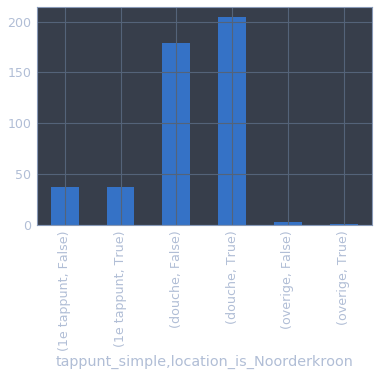

In [10]:
df_tmp.groupby(['tappunt_simple', 'location_is_Noorderkroon']).count()['id'].plot.bar()

In [18]:
df_tmp.groupby(['tappunt_simple', df_tmp.datetime.dt.hour, ]).count()['id']

tappunt_simple  datetime
1e tappunt      9            5
                10          10
                11           9
                12          19
                13          15
                14           9
                15           7
douche          8            1
                9            9
                10          50
                11          72
                12          72
                13          80
                14          85
                15          13
                16           1
overige         11           1
                13           3
Name: id, dtype: int64

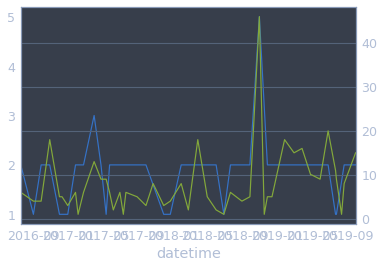

In [29]:
df_1 = df_tmp[df_tmp.tappunt_simple == '1e tappunt']
df_1.groupby([df_1.datetime.dt.date]).count()['id'].plot()
df_1 = df_tmp[df_tmp.tappunt_simple == 'douche']
df_1.groupby([df_1.datetime.dt.date]).count()['id'].plot(secondary_y=True)